# Cat-Specific EDA

## Questions we seek to answer
- What are the most common breeds?
- What is the distribution of intake types (stray vs. owner surrender)?
- What is the distribution of intake conditions?
- What are the most common outcomes?
- What factors are associated with euthanasia outcomes?
- Does breed affect outcome or length of stay?
- Does intake condition affect outcome or length of stay?
- Does intake type affect outcome or length of stay?
- Is spay/neuter status a factor in outcome or length of stay?
- Is age a factor in outcome or length of stay?


## Importing needed libraries/modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


## Load data

In [2]:
shelter_df = pd.read_csv("../data/animal_shelter_cleaned.csv")

# Convert date columns
shelter_df["date_of_birth"] = pd.to_datetime(shelter_df["date_of_birth"])
shelter_df["intake_date"] = pd.to_datetime(shelter_df["intake_date"])
shelter_df["outcome_date"] = pd.to_datetime(shelter_df["outcome_date"])

# Filter to Cats only
df = shelter_df[shelter_df["type"] == "CAT"].copy()
print(f"Total cats: {len(df):,}")
df.head()

Total cats: 11,361


,name,type,breed,color,sex,size,date_of_birth,impound_number,kennel_number,animal_id,...,outcome_condition,intake_jurisdiction,outcome_jurisdiction,outcome_zip_code,location,count,fixed,age_at_intake,age_at_outcome,age_group
10,BOOTS,CAT,DOMESTIC SH,BRN TABBY,Male,KITTN,2023-08-17,K23-047230,CA02,A421310,...,HEALTHY,SANTA ROSA,COUNTY,95407.0,"95407(38.4127094, -122.7412153)",1,Neutered,135.0,145.0,Young
14,Unknown,CAT,DOMESTIC SH,BRN TABBY,Male,KITTN,2024-04-04,K24-048105,TRUCK,A425690,...,HEALTHY,SANTA ROSA,*PETALUMA,94952.0,"94952(38.237, -122.640695)",1,Unaltered,2.0,2.0,Young
15,*TERRI,CAT,DOMESTIC SH,BRN TABBY,Female,SMALL,2023-07-19,K23-047160,CA02,A423448,...,HEALTHY,COUNTY,COUNTY,95407.0,"95407(38.4127094, -122.7412153)",1,Spayed,153.0,174.0,Young
21,Unknown,CAT,DOMESTIC SH,BLACK,Male,SMALL,NaT,K23-046821,HSSC,A422186,...,HEALTHY,COUNTY,NaN,NaN,NaN,1,Unaltered,NaN,NaN,NaN
24,Unknown,CAT,DOMESTIC SH,GRAY TABBY,Female,SMALL,2020-08-03,K23-045613,COOLER,A419441,...,DEAD,COUNTY,NaN,NaN,NaN,1,Spayed,1095.0,1100.0,Adult


## Visualization Functions

In [3]:
months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul",
          8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}


# Plot monthly outcomes/intakes and intake averages (single bar)
def monthly_single_bar(count, year, category):
    labels = [months[x] for x in count.index.values]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.patch.set_facecolor("#FFF0E6")
    ax.set_facecolor("#FFF0E6")
    
    bars = ax.bar(count.index.values, count, width=0.6, color="#7D6B7D")
    ax.bar_label(bars, fontsize=10)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    ax.yaxis.grid(True, color="white", linewidth=1)
    ax.set_axisbelow(True)
    
    ax.set_title(f"Number of {category} per Month ({year})", size=16, weight="light", pad=20)
    ax.set_ylabel(category)
    ax.set_xlabel("Month")
    ax.set_xticks(count.index.values)
    ax.set_xticklabels(labels)
    
    plt.tight_layout()
    plt.show()


# Plot monthly outcomes/intakes (double bar)
def monthly_in_out(intake_count, outcome_count, year, features):
    labels = [months[x] for x in intake_count.index.values]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor("#FFF0E6")
    ax.set_facecolor("#FFF0E6")

    x = np.arange(len(labels)) * 2
    width = 0.8
    multiplier = 0
    colors = ["#B5C4B1", "#7D6B7D"]

    for series in [intake_count, outcome_count]:
        offset = width * multiplier
        rects = ax.bar(x + offset, series, width, color=colors[multiplier], label=features[multiplier])
        ax.bar_label(rects, padding=5)
        multiplier += 1
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    ax.yaxis.grid(True, color="white", linewidth=1)
    ax.set_axisbelow(True)
    
    ax.set_title(f"Number of Intakes/Outcomes per Month ({year})", size=16, weight="light", pad=20)
    ax.set_ylabel("Count")
    ax.set_xlabel("Month")
    ax.set_xticks(x + (width/len(features)), labels)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [l.title() for l in labels], frameon=False, loc="upper left", ncols=3)
    plt.tight_layout()
    plt.show()


# Plot pie charts
def type_pie_chart(types, title):
    types_formatted = [f"{x.title()} ({v/types.sum()*100:.1f}%)"
                       for x, v in zip(types.index.values, types)]

    fig, ax = plt.subplots(figsize=(6, 3))
    fig.patch.set_facecolor("#FFF0E6")
    ax.set_facecolor("#FFF0E6")
    
    wedges, _ = ax.pie(types,
                       startangle=180,
                       colors=("#B5C4B1", "#7D6B7D", "#C9847A", "#F4ACB7", "#B8A9C9", "#E8C5A0", "#9DB4C0", "#9D8189", "#FFCAD4", "#D8E2DC"),
                       textprops={"color": "black"})

    ax.legend(wedges, types_formatted,
              loc="upper left",
              bbox_to_anchor=(1, 0, 0.5, 1),
              frameon=False)

    ax.set_title(title, size=16, weight="light")
    plt.show()


# Converts age in days to years
def convertAgeToYears(age):
    return age/365.24


# Requests user input for a specific year
def get_year_input():
    prompt = "Enter a year between 2014 and 2026: "
    year = input(prompt)
    while not year.isnumeric() or not (2014 <= int(year) <= 2026):
        print("Invalid input")
        year = input(prompt)
    return int(year)


## Preview the Data

In [4]:
display(df)

,name,type,breed,color,sex,size,date_of_birth,impound_number,kennel_number,animal_id,...,outcome_condition,intake_jurisdiction,outcome_jurisdiction,outcome_zip_code,location,count,fixed,age_at_intake,age_at_outcome,age_group
10,BOOTS,CAT,DOMESTIC SH,BRN TABBY,Male,KITTN,2023-08-17,K23-047230,CA02,A421310,...,HEALTHY,SANTA ROSA,COUNTY,95407.0,"95407(38.4127094, -122.7412153)",1,Neutered,135.0,145.0,Young
14,Unknown,CAT,DOMESTIC SH,BRN TABBY,Male,KITTN,2024-04-04,K24-048105,TRUCK,A425690,...,HEALTHY,SANTA ROSA,*PETALUMA,94952.0,"94952(38.237, -122.640695)",1,Unaltered,2.0,2.0,Young
15,*TERRI,CAT,DOMESTIC SH,BRN TABBY,Female,SMALL,2023-07-19,K23-047160,CA02,A423448,...,HEALTHY,COUNTY,COUNTY,95407.0,"95407(38.4127094, -122.7412153)",1,Spayed,153.0,174.0,Young
21,Unknown,CAT,DOMESTIC SH,BLACK,Male,SMALL,NaT,K23-046821,HSSC,A422186,...,HEALTHY,COUNTY,NaN,NaN,NaN,1,Unaltered,NaN,NaN,NaN
24,Unknown,CAT,DOMESTIC SH,GRAY TABBY,Female,SMALL,2020-08-03,K23-045613,COOLER,A419441,...,DEAD,COUNTY,NaN,NaN,NaN,1,Spayed,1095.0,1100.0,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32494,33347,CAT,DOMESTIC SH,WHITE/BLACK,Male,KITTN,2025-08-12,K25-053416,HSSC,A436743,...,PENDING,SANTA ROSA,COUNTY,95407.0,"95407(38.41483, -122.72707)",1,Unaltered,31.0,37.0,Young
32495,*SAL,CAT,DOMESTIC SH,BLACK/WHITE,Female,KITTN,2025-05-23,K25-052492,WESTFARM,A434856,...,HEALTHY,SANTA ROSA,SANTA ROSA,95409.0,"95409(38.46382, -122.67058)",1,Spayed,34.0,118.0,Young
32496,LUNA,CAT,DOMESTIC SH,BLACK,Female,SMALL,2025-06-03,K25-052530,WESTFARM,A434912,...,HEALTHY,SANTA ROSA,COUNTY,95403.0,"95403(38.51311, -122.75502)",1,Spayed,25.0,107.0,Young
32497,33318,CAT,DOMESTIC SH,BLUE,Unknown,KITTN,2025-08-05,K25-053327,HSSC,A436586,...,PENDING,COUNTY,COUNTY,95407.0,"95407(38.41483, -122.72707)",1,Unknown,31.0,44.0,Young


## Data Visualizations

### Breed Distribution

In [5]:
df["breed"].value_counts()

breed
DOMESTIC SH                8858
DOMESTIC MH                1107
DOMESTIC LH                 795
SIAMESE                     216
SIAMESE/MIX                 158
MANX                         21
PERSIAN                      19
HIMALAYAN                    18
ABYSSINIAN                   16
DOMESTIC SH/MIX              12
BENGAL                       11
EXOTIC SH                    11
SNOWSHOE/MIX                 10
HIMALAYAN/MIX                 9
SNOWSHOE                      8
MANX/MIX                      8
RUSSIAN BLUE                  6
ABYSSINIAN/MIX                6
BENGAL/MIX                    5
MAINE COON                    5
DOMESTIC LH/SIAMESE           4
PERSIAN/MIX                   3
SCOTTISH FOLD/MIX             3
DOMESTIC LH/MAINE COON        3
JAPAN BOBTAIL/MIX             2
MAINE COON/MIX                2
BENGAL/DOMESTIC SH            2
TURKISH ANGORA                2
SAVANNAH                      2
SCOTTISH FOLD                 2
DOMESTIC SH/ABYSSINIAN        2
DO

### Intake Type

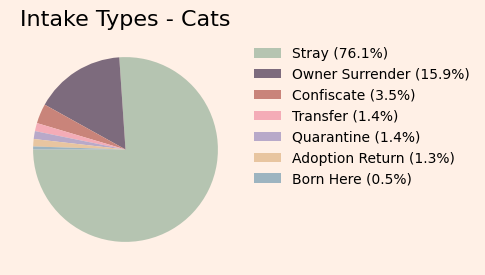

In [6]:
intake_types = df["intake_type"].value_counts()
type_pie_chart(intake_types, "Intake Types - Cats")

### Intake Condition

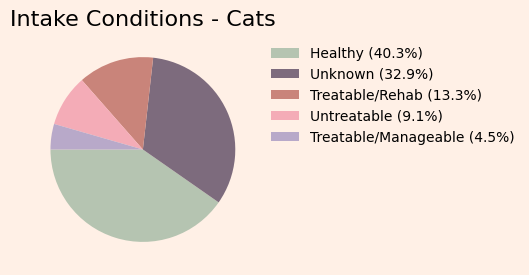

In [7]:
intake_conditions = df["intake_condition"].value_counts()
type_pie_chart(intake_conditions, "Intake Conditions - Cats")

### Outcome Types

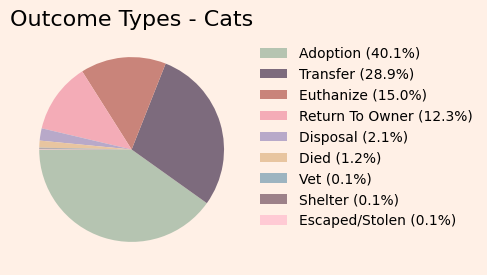

In [8]:
outcomes = df["outcome_type"].value_counts()
type_pie_chart(outcomes, "Outcome Types - Cats")

### Sex and Spay/Neuter Status

In [9]:
print(df["sex"].value_counts())
print()
print(df["fixed"].value_counts())

sex
Male       4857
Female     4801
Unknown    1703
Name: count, dtype: int64

fixed
Neutered     3766
Spayed       3446
Unaltered    2446
Unknown      1703
Name: count, dtype: int64


### Length of Stay

In [10]:
los = df["days_in_shelter"]

avg_los = los.mean()
median_los = los.median()

print(f"Mean length of stay: {avg_los:.3} days.")
print(f"Median length of stay: {median_los:.3} days.")
print(f"Animals staying longer than 30 days: {(los > 30).mean():.2%}")
print(f"Animals staying longer than 60 days: {(los > 60).mean():.2%}")

Mean length of stay: 19.4 days.
Median length of stay: 10.0 days.
Animals staying longer than 30 days: 23.01%
Animals staying longer than 60 days: 7.15%
